<a href="https://colab.research.google.com/github/Ala-ADN/Drugzello/blob/main/MEGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MEGAN implementation from diagram
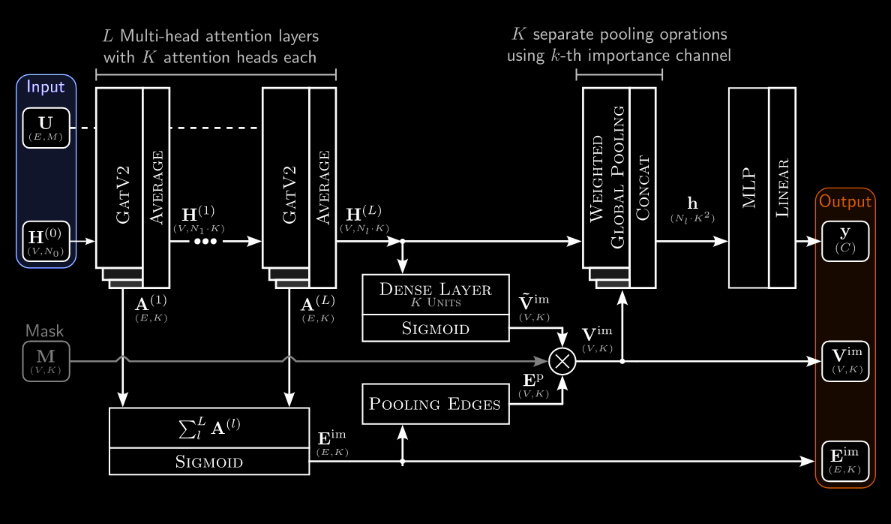

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00


In [ ]:
import copy
import inspect
from typing import Any, Callable, Dict, Final, List, Optional, Tuple, Union

import torch
from torch import Tensor
from torch.nn import Linear, ModuleList
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import CachedLoader, NeighborLoader
from torch_geometric.nn.conv import (
    EdgeConv,
    GATConv,
    GATv2Conv,
    GCNConv,
    GINConv,
    MessagePassing,
    PNAConv,
    SAGEConv,
)
from torch_geometric.nn.models import MLP
from torch_geometric.nn.models.jumping_knowledge import JumpingKnowledge
from torch_geometric.nn.resolver import (
    activation_resolver,
    normalization_resolver,
)
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils._trim_to_layer import TrimToLayer


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_add_pool
from torch_geometric.utils import add_self_loops


class GATv2WithLogits(GATv2Conv):
    """
    A GATv2Conv layer modified to explicitly store the raw attention logits (alpha)
    when requested. Compatible with torch-geometric >= 2.1
    Stores the attention logits in the `latest_logits` attribute when
    `return_attention=True` is passed to the forward method.
    """
    def __init__(self, *args, **kwargs):
        # Initialize the parent GATv2Conv layer
        super().__init__(*args, **kwargs)
        # Attribute to store the latest computed attention logits
        self.latest_logits: Optional[Tensor] = None # Shape: [num_edges, num_heads]

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Optional[Tensor] = None,
                return_attention: bool = False) -> Tensor:
        """
        Forward pass for the GATv2 layer.

        Args:
            x (Tensor): Node feature matrix [num_nodes, in_channels].
            edge_index (Tensor): Graph connectivity matrix [2, num_edges].
                 Should be LongTensor.
            edge_attr (Tensor, optional): Edge feature matrix [num_edges, edge_feat_dim].
                 Defaults to None.
            return_attention (bool, optional): If True, computes and stores the attention
                logits in `self.latest_logits`. Defaults to False.

        Returns:
            Tensor: Output node features.
                    Shape: [num_nodes, out_channels * heads] (if concat=True)
                    or [num_nodes, out_channels] (if concat=False).
        """
        # Call the original GATv2Conv forward pass, always requesting attention weights internally.
        # For PyG >= 2.1, setting return_attention_weights=True makes forward return
        # a tuple: (node_embeddings, (edge_index, attention_weights))
        # The attention_weights 'alpha' are typically the logits before softmax.
        out, (edge_index_out, alpha) = super().forward(x=x,
                                                       edge_index=edge_index,
                                                       edge_attr=edge_attr,
                                                       return_attention_weights=True) # Force computation

        if return_attention:
            # If requested by the caller, store the computed alpha
            # alpha shape is typically [num_edges, num_heads]
            self.latest_logits = alpha
        else:
            # Otherwise, ensure it's None (or clear previous value)
            self.latest_logits = None

        # Return only the node feature embeddings, maintaining the standard layer output
        return out


class MEGANCore(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, K=2, heads=1, add_self_loops=True):
        """
        Initialize MEGAN model

        Args:
            in_channels: Input feature dimension (F)
            hidden_channels: Hidden dimension (H)
            out_channels: Output dimension (C)
            K: Number of explanation channels (K)
            heads: Number of attention heads per channel (typically 1 based on diagram)
        """
        super().__init__()
        self.K = K
        self.num_layers = 2  # L=2 layers in the diagram
        self.add_self_loops = add_self_loops

        # Attention layers: L multi-head layers with K channels each
        # NOTE: Set concat=False since diagram shows we average across heads
        self.attn_layers = nn.ModuleList()
        for layer in range(self.num_layers):
            layer_heads = nn.ModuleList([
                GATv2WithLogits(
                    in_channels if layer == 0 else hidden_channels,
                    hidden_channels, heads=heads, concat=False,
                    add_self_loops=False  # We handle self-loops manually
                ) for _ in range(K)
            ])
            self.attn_layers.append(layer_heads)

        # Node importance projection per channel
        # Diagram shows a dense layer with K units followed by sigmoid
        self.node_proj = nn.ModuleList([
            nn.Linear(hidden_channels, 1) for _ in range(K)  # This is correct as hidden_channels
        ])

        # Final graph prediction MLP
        # From diagram: Input dimension is [N, K*hidden_channels]
        self.graph_pred = nn.Sequential(
            nn.Linear(K * hidden_channels, hidden_channels),  # This is correct
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, x, edge_index, batch):
        """
        Forward pass matching the architecture diagram

        Args:
            x: Node features [V, F]
            edge_index: Edge list [2, E]
            batch: Batch vector [V]

        Returns:
            out: Graph prediction [B, C]
            Eim: Edge importance [E, K]
            Vim: Node importance [V, K]
        """
        # Add self-loops if the flag is set
        if self.add_self_loops:
            edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        num_edges = edge_index.size(1)  # E (may include self-loops)

        # Initialize accumulated edge logits
        edge_logits_by_channel = [torch.zeros(num_edges, device=x.device) for _ in range(self.K)]

        # Process through L attention layers
        for layer in range(self.num_layers):
            H_l_k = []  # Will store [V, H] for each k
            A_l_k = []  # Will store [E, 1] for each k

            # Apply K attention channels
            for k, head in enumerate(self.attn_layers[layer]):
                # Apply GATv2 layer
                # Since concat=False, h_k has shape [V, H]
                h_k = F.elu(head(x, edge_index, return_attention=True))  # [V, H]

                # Get attention scores [E, heads]
                # Average if multiple heads per channel (diagram shows K channels, not necessarily K*heads)
                a_k = head.latest_logits.mean(dim=1)  # [E]
                a_k = a_k.unsqueeze(1)  # [E, 1]

                H_l_k.append(h_k)  # [V, H]
                A_l_k.append(a_k)  # [E, 1]

            # Average across K channels to get new node representations
            # This matches the AVERAGE block in the diagram
            x = torch.stack(H_l_k, dim=0).mean(dim=0)  # [V, H]

            # Accumulate attention scores for edge importance
            for k in range(self.K):
                edge_logits_by_channel[k] = edge_logits_by_channel[k] + A_l_k[k].squeeze()  # [E]

        # Edge importance computation ∑ₗ A⁽ˡ⁾ followed by sigmoid
        Eim = torch.stack(edge_logits_by_channel, dim=1)  # [E, K]
        Eim = torch.sigmoid(Eim)  # [E, K]

        # Node importance computation
        Vim = []
        for k in range(self.K):
            # Pooled edge importance (Eᵖ in diagram)
            pooled_edge_attn = torch.zeros(x.size(0), device=x.device)  # [V]
            pooled_edge_attn.index_add_(0, edge_index[0], Eim[:, k])  # [V]

            # Node projection (DENSE LAYER with K units in diagram)
            v_proj = torch.sigmoid(self.node_proj[k](x)).squeeze()  # [V]

            # Element-wise multiplication (⊗ in diagram)
            v_mask = (pooled_edge_attn * v_proj).unsqueeze(1)  # [V, 1]
            Vim.append(v_mask)

        # Final node importance
        Vim = torch.cat(Vim, dim=1)  # [V, K]

        # K separate pooling operations (WEIGHTED GLOBAL POOLING in diagram)
        pooled_per_channel = []
        for k in range(self.K):
            weighted_nodes = x * Vim[:, k].unsqueeze(1)  # [V, H]
            pooled = global_add_pool(weighted_nodes, batch)  # [B, H]
            pooled_per_channel.append(pooled)

        # Concatenate channel-wise pooled features (CONCAT in diagram)
        h = torch.cat(pooled_per_channel, dim=1)  # [B, K*H]

        # Apply MLP for final prediction
        out = self.graph_pred(h)  # [B, C]

        # Return graph prediction and explanations
        return out, Eim, Vim



In [ ]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 842.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install graphviz

In [ ]:
!pip show torch_geometric

Name: torch-geometric
Version: 2.6.1
Summary: Graph Neural Network Library for PyTorch
Home-page: https://pyg.org
Author: 
Author-email: Matthias Fey <matthias@pyg.org>
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: aiohttp, fsspec, jinja2, numpy, psutil, pyparsing, requests, tqdm
Required-by: 


In [ ]:
# Model Parameters
in_channels = 16
hidden_channels = 8
out_channels = 2
K = 2  # Number of explanation channels
heads = 3  # Number of attention heads

# Graph Structure Parameters
num_nodes_graph1 = 5
num_edges_graph1 = 8
num_nodes_graph2 = 7
num_edges_graph2 = 10
batch_size = 2  # Two graphs in the batch

total_nodes = num_nodes_graph1 + num_nodes_graph2
total_edges = num_edges_graph1 + num_edges_graph2

# Create dummy data with correct dimensions

# 1. Node Features: [total_nodes, in_channels]
x = torch.randn(total_nodes, in_channels)

# 2. Edge Index: [2, total_edges]
# For graph 1 (nodes 0 to num_nodes_graph1-1)
edge_index1_src = torch.randint(0, num_nodes_graph1, (num_edges_graph1,))
edge_index1_dst = torch.randint(0, num_nodes_graph1, (num_edges_graph1,))
edge_index1 = torch.stack([edge_index1_src, edge_index1_dst], dim=0)

# For graph 2 (nodes num_nodes_graph1 to total_nodes-1)
edge_index2_src = torch.randint(0, num_nodes_graph2, (num_edges_graph2,)) + num_nodes_graph1
edge_index2_dst = torch.randint(0, num_nodes_graph2, (num_edges_graph2,)) + num_nodes_graph1
edge_index2 = torch.stack([edge_index2_src, edge_index2_dst], dim=0)

# Concatenate edge indices
edge_index = torch.cat([edge_index1, edge_index2], dim=1)
edge_index = edge_index.long()  # Ensure proper type

# 3. Batch Vector: [total_nodes]
# Maps each node to its corresponding graph (0 or 1)
batch = torch.cat([
    torch.zeros(num_nodes_graph1, dtype=torch.long),
    torch.ones(num_nodes_graph2, dtype=torch.long)
])

# Model Instantiation
model = MEGANCore(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    K=K,
    heads=heads
)
model.eval()  # Set to evaluation mode
#import pdb; pdb.set_trace()
# Forward Pass
out, Eim, Vim = model(x, edge_index, batch)

# Verify dimensions
print("\n--- Output Shapes ---")
print(f"Output (out) shape: {out.shape}")          # Expected: [batch_size, out_channels] = [2, 2]
print(f"Edge Importance (Eim) shape: {Eim.shape}") # Expected: [total_edges, K] = [18, 3]
print(f"Node Importance (Vim) shape: {Vim.shape}") # Expected: [total_nodes, K] = [12, 3]

# Check intermediate tensor dimensions
print("\n--- Intermediate Shapes ---")
print(f"Node features (x) shape: {x.shape}")                # [total_nodes, in_channels] = [12, 16]
print(f"Edge index shape: {edge_index.shape}")              # [2, total_edges] = [2, 18]
print(f"Batch vector shape: {batch.shape}")                 # [total_nodes] = [12]

# First layer dimensions
layer0_head0 = model.attn_layers[0][0]
h0_out = layer0_head0(x, edge_index)
print(f"First layer output shape: {h0_out.shape}")         # [total_nodes, hidden_channels] = [12, 8]

try:
    # Visualize computation graph (requires graphviz)
    dot = make_dot(out, params=dict(list(model.named_parameters()) +
                                   [('x', x), ('edge_index', edge_index), ('batch', batch)]))
    dot.render("megan_core_computation_graph", format="png", cleanup=True)
    print("\nComputation graph saved to 'megan_core_computation_graph.png'")
except Exception as e:
    print(f"\nError rendering graph: {e}")
    print("Make sure Graphviz is installed for visualization.")


--- Output Shapes ---
Output (out) shape: torch.Size([2, 2])
Edge Importance (Eim) shape: torch.Size([30, 2])
Node Importance (Vim) shape: torch.Size([12, 2])

--- Intermediate Shapes ---
Node features (x) shape: torch.Size([12, 16])
Edge index shape: torch.Size([2, 18])
Batch vector shape: torch.Size([12])
First layer output shape: torch.Size([12, 8])

Computation graph saved to 'megan_core_computation_graph.png'


# **MEGAN** from [kgcnn package](https://kgcnn.readthedocs.io/en/latest/intro.html)

## Load Esol Data

In [1]:
!pip install kgcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━

In [2]:
from kgcnn.data.datasets.ESOLDataset import ESOLDataset
data = ESOLDataset()

ERROR:kgcnn.molecule.convert:Can not import `OpenBabel` package for conversion.
INFO:kgcnn.data.download:Checking and possibly downloading dataset with name ESOL
INFO:kgcnn.data.download:Dataset directory located at /root/.kgcnn/datasets
INFO:kgcnn.data.download:Downloading dataset... 
INFO:kgcnn.data.ESOL:Generating molecules and store /root/.kgcnn/datasets/ESOL/delaney-processed.sdf to disk...
INFO:kgcnn.data.ESOL: ... converted molecules 1128 from 1128
INFO:kgcnn.data.ESOL:Read molecules from mol-file.
INFO:kgcnn.data.ESOL: ... process molecules 0 from 1128
INFO:kgcnn.molecule.encoder:OneHotEncoder Symbol found ['O', 'C', 'N', 'S', 'Cl', 'P', 'F', 'I', 'Br', 'H']
INFO:kgcnn.molecule.encoder:OneHotEncoder Hybridization found [rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP, rdkit.Chem.rdchem.HybridizationType.SP2, rdkit.Chem.rdchem.HybridizationType.S]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalDegree found [2, 4, 1, 3]
INFO:kgcnn.molecule.encoder:

In [3]:
data[1000]

{'node_symbol': array(['C', 'C', 'O', 'C', 'O'], dtype='<U1'),
 'node_number': array([6, 6, 8, 6, 8]),
 'edge_indices': array([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1],
        [2, 3],
        [3, 2],
        [3, 4],
        [4, 3]]),
 'edge_number': array([1, 1, 1, 1, 1, 1, 2, 2]),
 'graph_size': array(5),
 'node_coordinates': array([[-1.2977,  0.1827, -0.4002],
        [-0.3075,  0.0844,  0.7451],
        [ 0.7212, -0.8655,  0.4307],
        [ 1.7825, -0.3745, -0.2555],
        [ 1.9433,  0.7745, -0.6331]]),
 'graph_labels': array(0.15),
 'node_attributes': array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 

In [4]:
from kgcnn.molecule.encoder import OneHotEncoder
data.read_in_memory(
    nodes = [
        'Symbol', 'TotalDegree', 'FormalCharge', 'NumRadicalElectrons', 'Hybridization',
        'IsAromatic', 'IsInRing', 'TotalNumHs', 'CIPCode', "ChiralityPossible", "ChiralTag"
    ],
    encoder_nodes = {
        'Symbol': OneHotEncoder(
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
            dtype="str"
        ),
        'Hybridization': OneHotEncoder([2, 3, 4, 5, 6]),
        'TotalDegree': OneHotEncoder([0, 1, 2, 3, 4, 5], add_unknown=False),
        'TotalNumHs': OneHotEncoder([0, 1, 2, 3, 4], add_unknown=False),
        'CIPCode': OneHotEncoder(['R', 'S'], add_unknown=False, dtype='str'),
        "ChiralityPossible": OneHotEncoder(["1"], add_unknown=False, dtype='str'),
    },
    edges = ['BondType', 'IsAromatic', 'IsConjugated', 'IsInRing', 'Stereo'],
    encoder_edges = {
        'BondType': OneHotEncoder([1, 2, 3, 12], add_unknown=False),
        'Stereo': OneHotEncoder([0, 1, 2, 3], add_unknown=False)
    },
    graph=['ExactMolWt', 'NumAtoms'],
    encoder_graph = {},
    add_hydrogen=False,
    make_directed=False,
    has_conformers=True,
    sanitize=True,
    compute_partial_charges=None,
    label_column_name="measured log solubility in mols per litre"
)

INFO:kgcnn.data.ESOL:Read molecules from mol-file.
INFO:kgcnn.data.ESOL: ... process molecules 0 from 1128
INFO:kgcnn.molecule.encoder:OneHotEncoder Symbol found ['O', 'C', 'N', 'S', 'Cl', 'P', 'F', 'I', 'Br', 'H']
INFO:kgcnn.molecule.encoder:OneHotEncoder Hybridization found [rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP, rdkit.Chem.rdchem.HybridizationType.SP2, rdkit.Chem.rdchem.HybridizationType.S]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalDegree found [2, 4, 1, 3]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalNumHs found [1, 2, 0, 3, 4]
INFO:kgcnn.molecule.encoder:OneHotEncoder CIPCode found [None, 'S', 'R']
INFO:kgcnn.molecule.encoder:OneHotEncoder ChiralityPossible found [None, '1']
INFO:kgcnn.molecule.encoder:OneHotEncoder BondType found [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC, rdkit.Chem.rdchem.BondType.DOUBLE]
INFO:kgcnn.molecule.encoder:OneHotEncoder Stereo found [rdkit.

<ESOLDataset [{'node_symbol': array(['O', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'O', 'C', 'O', 'C', 'C',
       'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'O',
       'C', 'O', 'C', 'O', 'C', 'O'], dtype='<U1'), 'node_number': array([8, 6, 6, 8, 6, 8, 6, 6, 8, 6, 8, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 8,
       6, 8, 6, 8, 6, 8, 6, 8, 6, 8]), 'edge_indices': array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2,  3],
       [ 2, 30],
       [ 3,  2],
       [ 3,  4],
       [ 4,  3],
       [ 4,  5],
       [ 4, 26],
       [ 5,  4],
       [ 5,  6],
       [ 6,  5],
       [ 6,  7],
       [ 7,  6],
       [ 7,  8],
       [ 7, 24],
       [ 8,  7],
       [ 8,  9],
       [ 9,  8],
       [ 9, 10],
       [ 9, 20],
       [10,  9],
       [10, 11],
       [11, 10],
       [11, 12],
       [11, 14],
       [12, 11],
       [12, 13],
       [13, 12],
       [14, 11],
       [14, 15],
       [14, 19],
       [15, 14],
       [15, 16],
       [16, 15],
  

In [5]:
from kgcnn.graph.preprocessor import SetRange, SetEdgeIndicesReverse
data.map_list(SetRange(max_distance=5.0, in_place=True)); #limit interaction range
data.map_list(SetEdgeIndicesReverse(in_place=True)); #un-direct the graph
data.map_list(method="count_nodes_and_edges"); #add edge and node count

In [6]:
len(data)

1128

In [7]:
data[0].keys()

dict_keys(['node_symbol', 'node_number', 'edge_indices', 'edge_number', 'graph_size', 'node_coordinates', 'graph_labels', 'node_attributes', 'edge_attributes', 'graph_attributes', 'range_indices', 'range_attributes', 'edge_indices_reverse', 'total_nodes', 'total_edges'])

In [8]:
data.clean("edge_indices")

INFO:kgcnn.data.ESOL:Property 'edge_indices' is an empty list for graph '934'.


array([934])

In [9]:
import numpy as np
labels = np.array(data.obtain_property("graph_labels"))
if len(labels.shape) <= 1:
    labels = np.expand_dims(labels, axis=-1)

In [10]:
data[1000]

{'node_symbol': array(['C', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], dtype='<U1'),
 'node_number': array([6, 7, 6, 6, 6, 6, 6, 6, 6]),
 'edge_indices': array([[0, 1],
        [1, 0],
        [1, 2],
        [1, 3],
        [2, 1],
        [3, 1],
        [3, 4],
        [3, 8],
        [4, 3],
        [4, 5],
        [5, 4],
        [5, 6],
        [6, 5],
        [6, 7],
        [7, 6],
        [7, 8],
        [8, 3],
        [8, 7]]),
 'edge_number': array([ 1,  1,  1,  1,  1,  1, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12]),
 'graph_size': array(9),
 'node_coordinates': array([[ 2.0883, -1.1967, -0.0782],
        [ 1.2788, -0.0401, -0.4571],
        [ 1.9968,  1.2298, -0.5469],
        [-0.0811, -0.0259, -0.1185],
        [-0.7691, -1.192 ,  0.2661],
        [-2.1332, -1.1862,  0.5904],
        [-2.8601, -0.0056,  0.5289],
        [-2.2216,  1.1626,  0.1369],
        [-0.8572,  1.1463, -0.1854]]),
 'graph_labels': array(-1.92),
 'node_attributes': array([[0., 1., 0., 0.,

### Show molecule for debugging

---



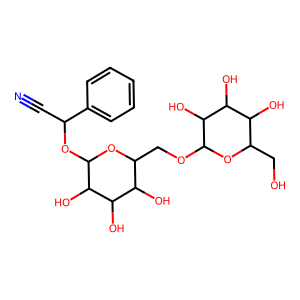

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw

m = data[0]
mol = Chem.RWMol()
node_symbols = m["node_symbol"]
edge_indices = m["edge_indices"]
edge_attrs = m["edge_attributes"]

# Add atoms
for symbol in node_symbols:
    mol.AddAtom(Chem.Atom(symbol))

# Define bond type mapping based on edge_attributes
bond_types = [
    Chem.BondType.SINGLE,
    Chem.BondType.DOUBLE,
    Chem.BondType.TRIPLE,
    Chem.BondType.AROMATIC
]

added = set()
for i, (a1, a2) in enumerate(edge_indices):
    bond_tuple = tuple(sorted((int(a1), int(a2))))
    if bond_tuple in added:
        continue
    added.add(bond_tuple)

    # Determine bond type from edge_attributes
    bond_type = Chem.BondType.SINGLE  # default
    attrs = edge_attrs[i]
    # Check first four elements for bond type
    for j in range(4):
        if attrs[j] == 1.0:
            bond_type = bond_types[j]
            break

    mol.AddBond(int(a1), int(a2), bond_type)

# Sanitize the molecule to adjust valences and aromaticity
mol.UpdatePropertyCache()
Chem.SanitizeMol(mol)
img = Draw.MolToImage(mol)
img

## Train model

In [12]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2, random_state=42, shuffle=True)
train_test_indices = [
    [train_index, test_index] for train_index, test_index in kf.split(X=np.zeros((len(data), 1)), y=labels)]

In [13]:
#TODO correct config and optimise hyper params
#config = {
#  "name": "kgcnn.literature.MEGAN",
#  "inputs": [
#    {
#      "shape": [None, 41],
#      "name": "node_attributes",
#      "dtype": "float32",
#      "ragged": True
#    },
#    {
#      "shape": [None, 2],
#      "name": "edge_indices",
#      "dtype": "int64",
#      "ragged": True
#    },
#    {
#      "shape": [None, 11],
#      "name": "edge_attributes",
#      "dtype": "float32",
#      "ragged": True
#    },
#    {
#      "shape": [None],
#      "name": "node_graph_indices",
#      "dtype": "int32",
#      "ragged": True
#    },
#    {
#      "shape": [None],
#      "name": "edge_graph_indices",
#      "dtype": "int32",
#      "ragged": True
#    }
#  ],
#  "input_tensor_type": "ragged",
#  "cast_disjoint_kwargs": {},
#  "input_node_embedding": {"input_dim": 41, "output_dim": 64},
#  "input_edge_embedding": {"input_dim": 11, "output_dim": 64},
#  "use_edge_features": True,
#  "units": [64, 64, 64, 64, 64],
#  "activation": "relu",
#  "use_bias": True,
#  "dropout_rate": 0.05,
#  "importance_units": [32],
#  "importance_channels": 1,
#  "importance_activation": "relu",
#  "importance_dropout_rate": 0.0,
#  "importance_factor": 0.0,
#  "importance_multiplier": 1.0,
#  "sparsity_factor": 0.0,
#  "concat_heads": True,
#  "final_pooling": "graph",
#  "final_units": [64, 32, 1],
#  "final_activation": "linear",
#  "final_dropout_rate": 0.0,
#  "regression_limits": None,
#  "regression_reference": None,
#  "return_importances": True,
#  "output_embedding": "graph",
#  "output_tensor_type": "padded"
#}
#----------------------------------------------
#basic config (no edges no explination)
config = {
    'name': "MEGAN",
    'units': [60, 50, 40, 30],
    'importance_units': [32, 16],
    'final_units': [50, 30, 10, 1],
    'dropout_rate': 0.3,
    'final_dropout_rate': 0.0,
    'importance_channels': 2,
    'return_importances': True,
    'use_edge_features': False,

    'inputs': [
        {'shape': (None, 41), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
        {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
        {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True},
        {'shape': (None,), 'name': "batch_indices", 'dtype': 'int64', 'ragged': True}
    ],

    'input_tensor_type': 'ragged',
    'output_tensor_type': 'padded',
    'output_embedding': 'graph',

    'activation': 'relu',
    'final_activation': 'linear',
    'final_pooling': 'sum'
}


In [15]:
import time
from kgcnn.models.utils import get_model_class
from keras.optimizers import Adam
from kgcnn.training.scheduler import LinearLearningRateScheduler
from kgcnn.literature.MEGAN import make_model
from kgcnn.data.transform.scaler.molecule import QMGraphLabelScaler
from kgcnn.data.transform.scaler.standard import StandardLabelScaler
from kgcnn.metrics.metrics import ScaledMeanAbsoluteError, ScaledRootMeanSquaredError
from datetime import timedelta

EPOCHS = 100

history_list, test_indices_list, test_importance_list = [], [], [] # Added test_importance_list
model, hist, x_test_fold_tensor, y_test_fold_scaled, scaler, atoms_test_fold = None, None, None, None, None, None
splits_done = 0

for i_fold, (train_index, test_index) in enumerate(train_test_indices):
    print("Running training on fold: %s" % i_fold)

    model = make_model(**config)

    # Add batch_indices to each graph in the dataset before creating tensors

    # First select training and test graphs from indices
    dataset_train_fold, dataset_test_fold = data[train_index], data[test_index]

    # Add batch_indices (safer to do it on the fold's data)
    for i_graph, g in enumerate(dataset_train_fold):
        g.set("batch_indices", np.zeros(g.get("node_attributes").shape[0], dtype=np.int64))
    for i_graph, g in enumerate(dataset_test_fold):
        g.set("batch_indices", np.zeros(g.get("node_attributes").shape[0], dtype=np.int64))

    x_train_tensors, y_train_values = dataset_train_fold.tensor(config["inputs"]), labels[train_index]
    x_test_fold_tensor, y_test_fold_values = dataset_test_fold.tensor(config["inputs"]), labels[test_index]

    atoms_train_fold = dataset_train_fold.get("node_number") # For scaler
    atoms_test_fold = dataset_test_fold.get("node_number") # For scaler

    scaler = StandardLabelScaler(with_std=True,with_mean=True, copy=True)
    scaler.fit(y_train_values, atomic_number=atoms_train_fold)
    y_train_scaled = scaler.transform(y_train_values, atomic_number=atoms_train_fold)
    y_test_fold_scaled = scaler.transform(y_test_fold_values, atomic_number=atoms_test_fold)

    scaler_scale = scaler.get_scaling()
    mae_metric = ScaledMeanAbsoluteError(scaler_scale.shape if scaler_scale is not None else (1,), name="scaled_mean_absolute_error")
    rms_metric = ScaledRootMeanSquaredError(scaler_scale.shape if scaler_scale is not None else (1,), name="scaled_root_mean_squared_error")
    if scaler.scale_ is not None:
        mae_metric.set_scale(scaler_scale)
        rms_metric.set_scale(scaler_scale)
    metrics_list = [mae_metric, rms_metric]

    model.compile(
        loss=["mean_absolute_error", None, None],  # Only first output supervised
        loss_weights=[1.0, 0.0, 0.0],              # Ignore 2nd and 3rd outputs
        metrics=[metrics_list, [], []],            # Apply metrics only to the 1st output
        optimizer=Adam(learning_rate=5e-4)
    )
    print("---- Model Output Inspection ----")
    if hasattr(model, 'outputs') and model.outputs:
        print(f"Number of model outputs: {len(model.outputs)}")
        for i, out_tensor in enumerate(model.outputs):
            print(f"Output {i}: Name: {out_tensor.name}, Shape: {out_tensor.shape}, Dtype: {out_tensor.dtype}")
            # Check if Keras somehow thinks this output itself is a more complex structure
            # This is usually for Keras's internal representation, not the tensor object type itself
            print(f"   Output {i} object type: {type(out_tensor)}")
            # Inspect model outputs once it's built
            output_shapes = [tuple(o.shape) for o in model.outputs]
            # Output 1 (index 0): regression target
            # Output 2 (index 1): edge importance
            # Output 3 (index 2): node importance

            edge_imp_dim = output_shapes[1][1]  # e.g., 2
            node_imp_dim = output_shapes[2][1]  # e.g., 2

            # Create dummy targets with correct shapes
            dummy_edge_importance_train = np.zeros((len(y_train_scaled), edge_imp_dim), dtype=np.float32)
            dummy_node_importance_train = np.zeros((len(y_train_scaled), node_imp_dim), dtype=np.float32)

            dummy_edge_importance_test = np.zeros((len(y_test_fold_scaled), edge_imp_dim), dtype=np.float32)
            dummy_node_importance_test = np.zeros((len(y_test_fold_scaled), node_imp_dim), dtype=np.float32)
    else:
        print("Model has no outputs attribute or outputs list is empty.")
    print("-------------------------------")
    model.summary() # Also useful
    # Start and time training
    start = time.process_time()
    # The targets [y_train_scaled, [], []] match the model's three outputs.
    # If the second output is attention (unsupervised), [] is the correct "dummy" target.
    hist = model.fit(x_train_tensors,(y_train_scaled, dummy_edge_importance_train, dummy_node_importance_train),
                       validation_data=(x_test_fold_tensor, (y_test_fold_scaled, dummy_edge_importance_test, dummy_node_importance_test)),
                       batch_size=32,
                       epochs=EPOCHS,
                       validation_freq=10,
                       verbose=2,
                       callbacks=[
                           LinearLearningRateScheduler(
                               learning_rate_start=0.001, learning_rate_stop=1e-05, epo_min=EPOCHS//2, epo=EPOCHS)
                       ])
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))

    # Get loss from history
    history_list.append(hist)
    test_indices_list.append(test_index) # Store only test_index for this fold, or [train_index, test_index]

    # --- NEW PART: Retrieve and store importance scores for the test set of this fold ---
    all_outputs_fold_test = model.predict(x_test_fold_tensor)

    # CRUCIAL: Assuming model.outputs[1] (the second element of the list returned by predict)
    # now contains the attention coefficients due to the config modification.
    # If this assumption is incorrect (i.e., kgcnn's MEGAN was not modified or doesn't support
    # outputting attention this way), then all_outputs_fold_test[1] will be
    # whatever the model's second output is by default (e.g., coordinates).

    # Importance scores (e.g., attention coefficients)
    # Their shape will be (total_nodes_in_batch, num_attention_heads or 1)
    # or (num_graphs_in_batch, max_nodes_in_graph, num_attention_heads or 1) if padded.
    importance_scores_fold_test = all_outputs_fold_test[1]

    test_importance_list.append(importance_scores_fold_test)
    print(f"Fold {i_fold}: Shape of extracted importance scores: {importance_scores_fold_test.shape if isinstance(importance_scores_fold_test, np.ndarray) else 'N/A'}")

    splits_done = splits_done + 1

# After the loop, 'test_importance_list' will contain the importance scores
# (e.g., attention coefficients) for each fold's test set.
# For example:
# for i_fold, importance_data in enumerate(test_importance_list):
# print(f"Importance scores for fold {i_fold} test set (first 5 nodes/graphs if applicable):")
# print(importance_data[:5])

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'MEGAN', 'inputs': [{'shape': (None, 41), 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 1), 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None,), 'name': 'batch_indices', 'dtype': 'int64', 'ragged': True}], 'input_tensor_type': 'ragged', 'input_embedding': None, 'cast_disjoint_kwargs': {}, 'units': [60, 50, 40, 30], 'activation': 'relu', 'use_bias': True, 'dropout_rate': 0.3, 'use_edge_features': False, 'input_node_embedding': None, 'importance_units': [32, 16], 'importance_channels': 2, 'importance_activation': 'sigmoid', 'importance_dropout_rate': 0.0, 'importance_factor': 0.0, 'importance_multiplier': 10.0, 'sparsity_factor': 0.0, 'concat_heads': True, 'final_units': [50, 30, 10, 1], 'final_dropout_rate': 0.0, 'final_activation': 'linear', 'final_pooling': 'sum', 'regression_limits': No

Running training on fold: 0
---- Model Output Inspection ----
Number of model outputs: 3
Output 0: Name: keras_tensor_35, Shape: (None, 1), Dtype: float32
   Output 0 object type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Output 1: Name: keras_tensor_36, Shape: (None, 2), Dtype: float32
   Output 1 object type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Output 2: Name: keras_tensor_37, Shape: (None, 2), Dtype: float32
   Output 2 object type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
-------------------------------


Model: "MEGAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ node_attributes     │ (None, None, 41)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_indices        │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_attributes     │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_ragged_indice… │ [(None, 41), (2,  │          0 │ node_attributes[… │
│ (CastRaggedIndices… │ None), (None),    │            │ edge_indices[0][… │
│                     │ (None), (None),   │            │                   │
│                     │ (None), (None),   │            │                   │
│                     │ (None)]           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_ragged_attrib… │ [(None, 1),       │          0 │ edge_attributes[… │
│ (CastRaggedAttribu… │ (None), (None),   │            │                   │
│                     │ (None)]           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_indices       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ megan_1 (MEGAN)     │ [(None, 1),       │    100,655 │ cast_ragged_indi… │
│                     │ (None, 2), (None, │            │ cast_ragged_attr… │
│                     │ 2)]               │            │ cast_ragged_indi… │
│                     │                   │            │ batch_indices[0]… │
│                     │                   │            │ cast_ragged_indi… │
│                     │                   │            │ cast_ragged_indi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_disjoint_to_b… │ [(None, 1),       │          0 │ megan_1[0][0],    │
│ (CastDisjointToBat… │ (None, 2), (None, │            │ megan_1[0][1],    │
│                     │ 2)]               │            │ megan_1[0][2]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,655 (393.18 KB)

 Trainable params: 100,655 (393.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 - 17s - 969ms/step - cast_disjoint_to_batched_graph_state_1_scaled_mean_absolute_error: 1.6107 - cast_disjoint_to_batched_graph_state_1_scaled_root_mean_squared_error: 2.0285 - loss: 0.7714 - learning_rate: 1.0000e-03
Epoch 2/100
18/18 - 1s - 58ms/step - cast_disjoint_to_batched_graph_state_1_scaled_mean_absolute_error: 1.5342 - cast_disjoint_to_batched_graph_state_1_scaled_root_mean_squared_error: 1.9155 - loss: 0.7348 - learning_rate: 1.0000e-03
Epoch 3/100
18/18 - 1s - 36ms/step - cast_disjoint_to_batched_graph_state_1_scaled_mean_absolute_error: 1.4401 - cast_disjoint_to_batched_graph_state_1_scaled_root_mean_squared_error: 1.7999 - loss: 0.6898 - learning_rate: 1.0000e-03
Epoch 4/100
18/18 - 1s - 33ms/step - cast_disjoint_to_batched_graph_state_1_scaled_mean_absolute_error: 1.3983 - cast_disjoint_to_batched_graph_state_1_scaled_root_mean_squared_error: 1.7406 - loss: 0.6697 - learning_rate: 1.0000e-03
Epoch 5/100
18/18 - 1s - 35ms/step - cast_disjoint_to_batched_

INFO:kgcnn.models.utils:Updated model kwargs: '{'name': 'MEGAN', 'inputs': [{'shape': (None, 41), 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 1), 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None,), 'name': 'batch_indices', 'dtype': 'int64', 'ragged': True}], 'input_tensor_type': 'ragged', 'input_embedding': None, 'cast_disjoint_kwargs': {}, 'units': [60, 50, 40, 30], 'activation': 'relu', 'use_bias': True, 'dropout_rate': 0.3, 'use_edge_features': False, 'input_node_embedding': None, 'importance_units': [32, 16], 'importance_channels': 2, 'importance_activation': 'sigmoid', 'importance_dropout_rate': 0.0, 'importance_factor': 0.0, 'importance_multiplier': 10.0, 'sparsity_factor': 0.0, 'concat_heads': True, 'final_units': [50, 30, 10, 1], 'final_dropout_rate': 0.0, 'final_activation': 'linear', 'final_pooling': 'sum', 'regression_limits': No

Fold 0: Shape of extracted importance scores: (7623, 2)
Running training on fold: 1
---- Model Output Inspection ----
Number of model outputs: 3
Output 0: Name: keras_tensor_54, Shape: (None, 1), Dtype: float32
   Output 0 object type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Output 1: Name: keras_tensor_55, Shape: (None, 2), Dtype: float32
   Output 1 object type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Output 2: Name: keras_tensor_56, Shape: (None, 2), Dtype: float32
   Output 2 object type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
-------------------------------


Model: "MEGAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ node_attributes     │ (None, None, 41)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_indices        │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ edge_attributes     │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_ragged_indice… │ [(None, 41), (2,  │          0 │ node_attributes[… │
│ (CastRaggedIndices… │ None), (None),    │            │ edge_indices[0][… │
│                     │ (None), (None),   │            │                   │
│                     │ (None), (None),   │            │                   │
│                     │ (None)]           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_ragged_attrib… │ [(None, 1),       │          0 │ edge_attributes[… │
│ (CastRaggedAttribu… │ (None), (None),   │            │                   │
│                     │ (None)]           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_indices       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ megan_2 (MEGAN)     │ [(None, 1),       │    100,655 │ cast_ragged_indi… │
│                     │ (None, 2), (None, │            │ cast_ragged_attr… │
│                     │ 2)]               │            │ cast_ragged_indi… │
│                     │                   │            │ batch_indices[0]… │
│                     │                   │            │ cast_ragged_indi… │
│                     │                   │            │ cast_ragged_indi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_disjoint_to_b… │ [(None, 1),       │          0 │ megan_2[0][0],    │
│ (CastDisjointToBat… │ (None, 2), (None, │            │ megan_2[0][1],    │
│                     │ 2)]               │            │ megan_2[0][2]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,655 (393.18 KB)

 Trainable params: 100,655 (393.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 - 17s - 927ms/step - cast_disjoint_to_batched_graph_state_2_scaled_mean_absolute_error: 1.6388 - cast_disjoint_to_batched_graph_state_2_scaled_root_mean_squared_error: 2.0158 - loss: 0.7811 - learning_rate: 1.0000e-03
Epoch 2/100
18/18 - 1s - 30ms/step - cast_disjoint_to_batched_graph_state_2_scaled_mean_absolute_error: 1.5199 - cast_disjoint_to_batched_graph_state_2_scaled_root_mean_squared_error: 1.8863 - loss: 0.7244 - learning_rate: 1.0000e-03
Epoch 3/100
18/18 - 1s - 34ms/step - cast_disjoint_to_batched_graph_state_2_scaled_mean_absolute_error: 1.4096 - cast_disjoint_to_batched_graph_state_2_scaled_root_mean_squared_error: 1.7222 - loss: 0.6718 - learning_rate: 1.0000e-03
Epoch 4/100
18/18 - 1s - 36ms/step - cast_disjoint_to_batched_graph_state_2_scaled_mean_absolute_error: 1.2922 - cast_disjoint_to_batched_graph_state_2_scaled_root_mean_squared_error: 1.6235 - loss: 0.6159 - learning_rate: 1.0000e-03
Epoch 5/100
18/18 - 1s - 30ms/step - cast_disjoint_to_batched_

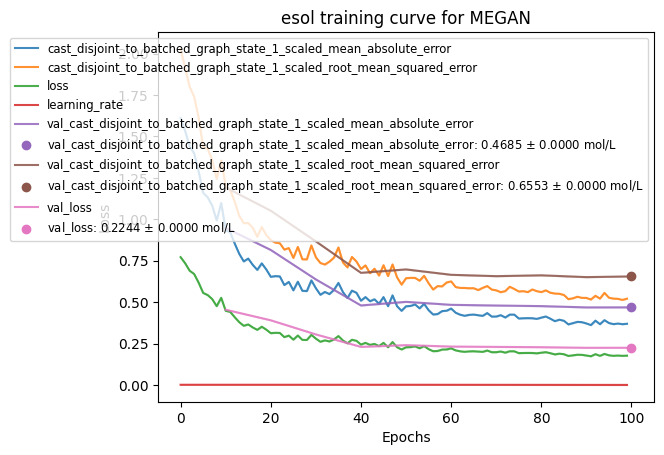

In [25]:
from kgcnn.utils.plots import plot_train_test_loss, plot_predict_true
filtered_histories = [
    h for h in history_list
    if 'cast_disjoint_to_batched_graph_state_1_scaled_mean_absolute_error' in h.history
]

plot_train_test_loss(filtered_histories, loss_name=None, val_loss_name=None,
                     model_name="MEGAN", data_unit="mol/L", dataset_name="esol",
                     filepath="", file_name=f"loss.png");

In [18]:
print(history_list[0].history.keys())

dict_keys(['cast_disjoint_to_batched_graph_state_1_scaled_mean_absolute_error', 'cast_disjoint_to_batched_graph_state_1_scaled_root_mean_squared_error', 'loss', 'learning_rate', 'val_cast_disjoint_to_batched_graph_state_1_scaled_mean_absolute_error', 'val_cast_disjoint_to_batched_graph_state_1_scaled_root_mean_squared_error', 'val_loss'])
